In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
import pandas as pd
import numpy as np
import torch
from navec import Navec
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CycleGAN_for_TST_problem/data.csv")

In [ ]:
df.head()

,lit_text,tg_text
0,Пьер с Анной Михайловной прошли в .,За это ему платили по тысяч за раз.
1,На пороге дома барон остановился в нерешительн...,больше почти ничего не помню
2,Вся церемония продолжалась около часа.,"ребята,срочняк косарь нужен подкинете на постр..."
3,"Вы, видите ли, еще, может, надумали бы дать ей...",некоторые из любопытства заходят на твою стран...
4,Во избежание такой неприятности я приостановил...,Пойду дальше рен ТВ смотреть


## Подготовка векторных представлений слов и знаков пунктуации

In [ ]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
embeddings = list()
for word in navec.vocab.words:
        embeddings.append(navec[word])
embeddings = np.array(embeddings)
embeddings.shape

(500002, 300)

In [ ]:
target_dim = 10
pca = PCA(n_components=target_dim)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings.shape

(500002, 10)

In [ ]:
reduced_navec = {word: np.array(reduced_embeddings[i], dtype=np.float16) for i, word in enumerate(navec.vocab.words)}

In [ ]:
punkt_vectors = {
    ".": np.array([0.0] * (target_dim - 1) + [1.0], dtype=np.float16),
    "!": np.array([0.0] * (target_dim - 1) + [0.9], dtype=np.float16),
    "?": np.array([0.0] * (target_dim - 1) + [0.8], dtype=np.float16),
    ",": np.array([0.0] * (target_dim - 1) + [0.5], dtype=np.float16),
    ":": np.array([0.0] * (target_dim - 1) + [0.6], dtype=np.float16),
    "–": np.array([0.0] * (target_dim - 1) + [0.4], dtype=np.float16),
    "-": np.array([0.0] * (target_dim - 1) + [0.4], dtype=np.float16),
    "—": np.array([0.0] * (target_dim - 1) + [0.4], dtype=np.float16),
    "«": np.array([0.0] * (target_dim - 1) + [0.2], dtype=np.float16),
    "»": np.array([0.0] * (target_dim - 1) + [0.3], dtype=np.float16),
}

## Изучение размеров токенизированных предложений

In [ ]:
vector_lengths = Counter(len(word_tokenize(line)) for line in df.lit_text)

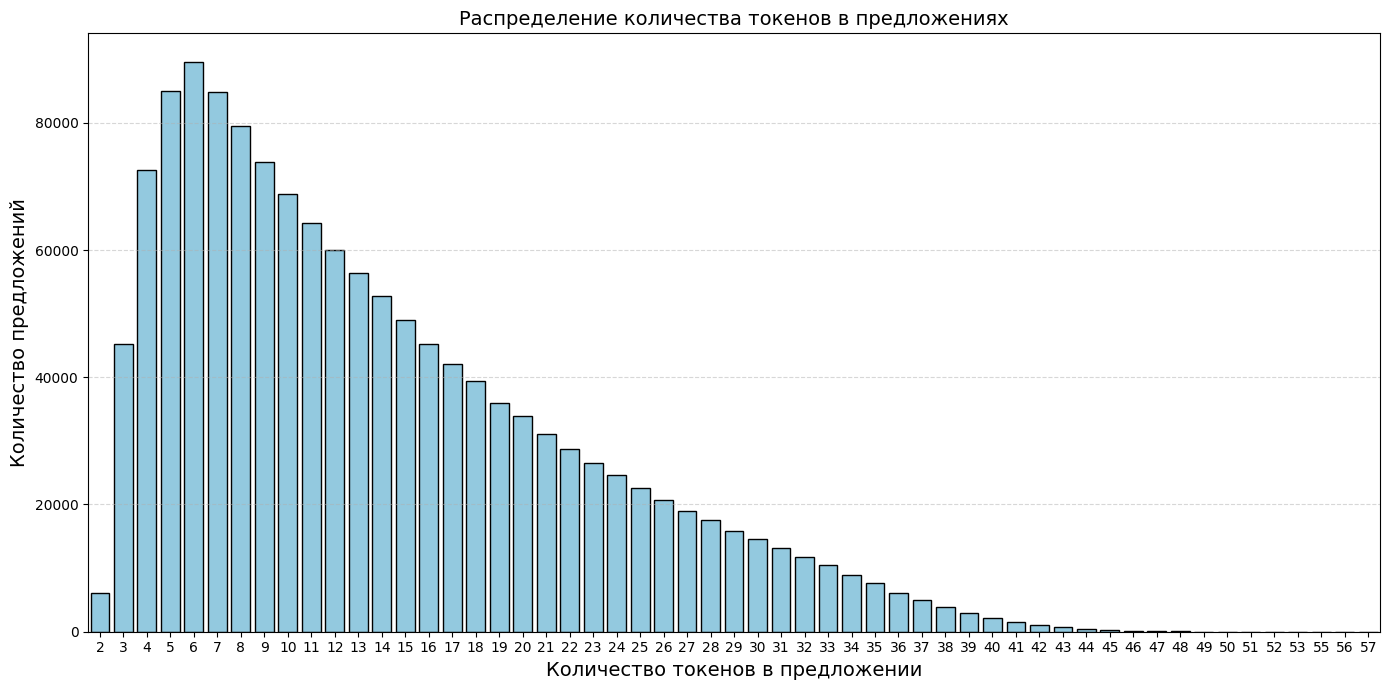

In [ ]:
lengths = sorted(vector_lengths.keys())
counts = [vector_lengths[length] for length in lengths]
plt.figure(figsize=(14, 7))
data = pd.DataFrame({'Length': lengths, 'Count': counts})
sb.barplot(data=data, x='Length', y='Count', color='skyblue', edgecolor='black')
plt.xlabel('Количество токенов в предложении', fontsize=14)
plt.ylabel('Количество предложений', fontsize=14)
plt.title('Распределение количества токенов в предложениях', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

In [ ]:
max_vector_length = 40

## Векторизация литературы

In [ ]:
lit_tokens = []
for sentence in df.lit_text:
    tokens = word_tokenize(sentence)
    if len(tokens) > max_vector_length:
        continue
    else:
        lit_tokens.append(tokens)

In [ ]:
len(lit_tokens)

1378261

In [ ]:
lit_vectors = list()
for i, tokens in enumerate(lit_tokens):
    padding_for = max_vector_length - len(tokens)
    vector = [np.zeros(target_dim)] * padding_for
    for word in tokens:
        try:
            vector.append(reduced_navec[word])
        except KeyError:
            try:
                vector.append(punkt_vectors[word])
            except KeyError:
                vector.append(reduced_navec["<unk>"])
    vector = np.array(vector, dtype=np.float16).reshape(max_vector_length * target_dim)
    lit_vectors.append(vector)

## Векторизация тг сообщений

In [ ]:
tg_tokens = []
for sentence in df.tg_text:
    tokens = word_tokenize(sentence)
    if len(tokens) > max_vector_length:
        continue
    else:
        tg_tokens.append(tokens)

In [ ]:
len(tg_tokens)

1382298

In [ ]:
tg_vectors = list()
for i, tokens in enumerate(tg_tokens):
    padding_for = max_vector_length - len(tokens)
    vector = [np.zeros(target_dim)] * padding_for
    for word in tokens:
        try:
            vector.append(reduced_navec[word])
        except KeyError:
            try:
                vector.append(punkt_vectors[word])
            except KeyError:
                vector.append(reduced_navec["<unk>"])
    vector = np.array(vector, dtype=np.float16).reshape(max_vector_length * target_dim)
    tg_vectors.append(vector)

## Сохранение векторов

In [ ]:
length = min(len(lit_vectors), len(tg_vectors))
length

1378261

In [ ]:
lit_vectors_np = np.array(lit_vectors[:length])
tg_vectors_np = np.array(tg_vectors[:length])

In [ ]:
np.save("/content/drive/MyDrive/CycleGAN_for_TST_problem/vectorized_lit.npy", lit_vectors_np)
np.save("/content/drive/MyDrive/CycleGAN_for_TST_problem/vectorized_tg.npy", tg_vectors_np)